# 0.0 Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from IPython.display import display
from sklearn.model_selection import cross_validate, KFold
import matplotlib.pyplot as plt
import matplotlib.pyplot as pltimport 
import tensorflow as tf
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import pickle
import csv
%matplotlib inline

In [3]:
def confusion_matrix_data(pred, y_test):

    home_goals_pred = []
    away_goals_pred = []
    home_goals_test = []
    away_goals_test = []

    for i in range(len(pred)):
        home_goals_pred.append(pred[i][0])
        away_goals_pred.append(pred[i][-1])

    for i in range(len(y_test)):
        home_goals_test.append(y_test[i][0])
        away_goals_test.append(y_test[i][-1])    

    columns=['home_goals_pred', 'away_goals_pred', 'home_goals_test', 'away_goals_test']

    df_pred = pd.DataFrame(list(zip(home_goals_pred, away_goals_pred, home_goals_test, away_goals_test)), columns=columns)

    df_pred['result_pred'] = 0
    df_pred.loc[df_pred['home_goals_pred'] == df_pred['away_goals_pred'], 'result'] = 0
    df_pred.loc[df_pred['home_goals_pred'] > df_pred['away_goals_pred'], 'result'] = 1
    df_pred.loc[df_pred['home_goals_pred'] < df_pred['away_goals_pred'], 'result'] = 2

    df_pred['result_test'] = 0
    df_pred.loc[df_pred['home_goals_test'] == df_pred['away_goals_test'], 'result_test'] = 0
    df_pred.loc[df_pred['home_goals_test'] > df_pred['away_goals_test'], 'result_test'] = 1
    df_pred.loc[df_pred['home_goals_test'] < df_pred['away_goals_test'], 'result_test'] = 2

    return df_pred

# 1.0 Data Wrangling

## 1.1 Read CSV

In [4]:
df_ratings = pd.read_csv('all_ratings_world_cup.csv').drop(['Unnamed: 0'], axis=1)
df_games = pd.read_csv('all_games_world_cup.csv').drop(['Unnamed: 0'], axis=1)

In [5]:
df_games.head()

,home_teams,away_teams,home_goals,away_goals,year
0,russia,saudi arabia,5,0,2018
1,egypt,uruguay,0,1,2018
2,morocco,ir iran,0,1,2018
3,portugal,spain,3,3,2018
4,france,australia,2,1,2018


In [6]:
df_ratings.head()

,rank,team,rating,year
0,1,germany,1558,2018
1,2,brazil,1431,2018
2,3,belgium,1298,2018
3,4,portugal,1274,2018
4,5,argentina,1241,2018


## 1.2 Creating separated ratings

In [7]:
df_home_ratings = df_ratings[['team', 'rank', 'rating', 'year']]
df_away_ratings = df_ratings[['team', 'rank', 'rating', 'year']]

df_home_ratings = df_home_ratings.rename(columns={'team': 'home_teams'})
df_away_ratings = df_away_ratings.rename(columns={'team': 'away_teams'})

## 1.3 Renaming countries

### 1.3.1 Games DF

In [8]:
df_games.loc[df_games['home_teams'] == 'united states', 'home_teams'] = 'usa'
df_games.loc[df_games['home_teams'] == 'ir iran', 'home_teams'] = 'iran'
df_games.loc[df_games['home_teams'] == 'Bosnia and Herzegovina', 'home_teams'] = 'bosnia-herzegovina'

df_games.loc[df_games['away_teams'] == 'united states', 'away_teams'] = 'usa'
df_games.loc[df_games['away_teams'] == 'ir iran', 'away_teams'] = 'iran'
df_games.loc[df_games['away_teams'] == 'Bosnia and Herzegovina', 'away_teams'] = 'bosnia-herzegovina'

### 1.3.2 Ratings DF

In [9]:
df_home_ratings.loc[df_home_ratings['home_teams'] == 'ir iran', 'home_teams'] = 'iran'
df_home_ratings.loc[df_home_ratings['home_teams'] == 'bosnia and herzegovina', 'home_teams'] = 'bosnia-herzegovina'

df_away_ratings.loc[df_away_ratings['away_teams'] == 'ir iran', 'away_teams'] = 'iran'
df_away_ratings.loc[df_away_ratings['away_teams'] == 'bosnia and herzegovina', 'away_teams'] = 'bosnia-herzegovina'

## 1.4 Merging DFs

In [10]:
df_games_ratings = df_games.merge(df_home_ratings, how='left', on=['home_teams', 'year'])
df_games_ratings.loc[df_games_ratings['home_teams'] == 'korea dpr', 'rating'] = 285

df_games_ratings_final = df_games_ratings.merge(df_away_ratings, how='left', on=['away_teams', 'year'])
df_games_ratings_final.loc[df_games_ratings_final['away_teams'] == 'korea dpr', 'rating_y'] = 285

### 1.4.1 Renaming ratings columns

In [11]:
df_games_ratings_final = df_games_ratings_final.rename(columns={'rating_x': 'rating_home_teams', 'rating_y': 'rating_away_teams'})

In [12]:
df_games_ratings_final[df_games_ratings_final['home_teams'] == 'russia']

,home_teams,away_teams,home_goals,away_goals,year,rank_x,rating_home_teams,rank_y,rating_away_teams
0,russia,saudi arabia,5,0,2018,70.0,457.0,67.0,465.0
16,russia,egypt,3,1,2018,70.0,457.0,45.0,649.0
64,russia,korea republic,1,1,2014,19.0,893.0,57.0,547.0
206,russia,tunisia,2,0,2002,28.0,644.0,31.0,635.0
319,russia,cameroon,6,1,1994,19.0,50.0,24.0,46.0


### 1.4.2 Dropping team names columns

In [13]:
df_final = df_games_ratings_final.drop(['home_teams', 'away_teams'], axis=1)

In [14]:
df_final.head()

,home_goals,away_goals,year,rank_x,rating_home_teams,rank_y,rating_away_teams
0,5,0,2018,70.0,457.0,67.0,465.0
1,0,1,2018,45.0,649.0,14.0,1018.0
2,0,1,2018,41.0,686.0,37.0,708.0
3,3,3,2018,4.0,1274.0,10.0,1126.0
4,2,1,2018,7.0,1198.0,36.0,718.0


## 1.5 Creating Results Column

In [15]:
df_final['results'] = 0

df_final.loc[df_final['home_goals'] == df_final['away_goals'], 'results'] = 0
df_final.loc[df_final['home_goals'] > df_final['away_goals'], 'results'] = 1
df_final.loc[df_final['home_goals'] < df_final['away_goals'], 'results'] = 2

In [16]:
df_final.head()

,home_goals,away_goals,year,rank_x,rating_home_teams,rank_y,rating_away_teams,results
0,5,0,2018,70.0,457.0,67.0,465.0,1
1,0,1,2018,45.0,649.0,14.0,1018.0,2
2,0,1,2018,41.0,686.0,37.0,708.0,2
3,3,3,2018,4.0,1274.0,10.0,1126.0,0
4,2,1,2018,7.0,1198.0,36.0,718.0,1


# 2.0 Model Creation

## 2.1 Features and Labels

In [17]:
df_final_ = df_final[(df_final['year'] != 1994) & (df_final['year'] != 1998)]

In [18]:
df_final_['rating_diff'] = abs(df_final_['rating_home_teams'] - df_final_['rating_away_teams'])

<ipython-input-18-ed00235dc8ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_['rating_diff'] = abs(df_final_['rating_home_teams'] - df_final_['rating_away_teams'])


In [19]:
df_final_no_outliers = df_final_.drop(df_final_[((df_final_['rating_diff']) > 900)].index)

In [20]:
features_no_outliers = df_final_no_outliers[['rating_home_teams', 'rating_away_teams']]
features = df_final_[['rating_home_teams', 'rating_away_teams']]
labels = df_final_[['home_goals', 'away_goals']]
labels_no_outliers = df_final_no_outliers[['home_goals', 'away_goals']]

## 2.2 MinMax features

In [21]:
scaler = MinMaxScaler().fit(features_no_outliers)
features_scale = scaler.transform(features_no_outliers)

In [22]:
X = features_scale
y = labels_no_outliers.values

## 2.3 Splitting in train and test

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.7)

In [24]:
len(y_test)

71

## 2.4 MultiOutputClassifier Model

<AxesSubplot:xlabel='previsao', ylabel='real'>

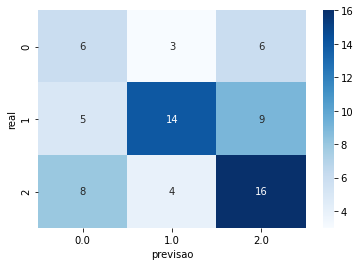

In [26]:
knn = KNeighborsClassifier(n_neighbors=31)
clf_MO = MultiOutputClassifier(knn, n_jobs=-1)
clf_MO.fit(X_train, y_train)
pred_multi = clf_MO.predict(X_test)


df_pred = confusion_matrix_data(pred_multi, y_test)

cf_matrix=pd.crosstab(df_pred['result_test'], df_pred['result'], rownames=['real'], colnames=['previsao'])

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [72]:
prediction_final = pd.read_csv('prediction_games_22.csv').drop(['Unnamed: 0'], axis=1)

In [73]:
prediction_final

,avg_points_x,avg_points_y
0,1559.945,1648.695
1,1635.690,1867.255
2,1824.235,1690.805
3,1712.740,1679.910
4,1882.390,1603.860
5,1818.785,1597.270
6,1732.945,1678.795
7,1957.440,1538.890
8,1920.855,1620.000
9,1880.110,1623.295


In [74]:
scaler = MinMaxScaler().fit(prediction_final)
features_scale = scaler.transform(prediction_final)

In [75]:
final_predictions = clf_MO.predict(features_scale)

In [76]:
final_predictions = final_predictions.tolist()

In [70]:
final_predictions.insert(0, ['home_goals', 'away_goals'])

In [71]:
with open("world_cup_predictions.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(final_predictions)

In [77]:
with open("sigma_geek_world_cup_predictions.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(final_predictions)

## 2.5 Decision tree model

In [1085]:
# decision tree

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
pred_tree = clf.predict(X_test)

#dt_acc = accuracy_score(y_test, pred)
#f1 = f1_score(y_test, pred, average = 'macro')

#print(f"Accuracy LogisticRegression: {dt_acc}")
#print(f"F1 Score: {f1}")

In [1179]:
df_pred = confusion_matrix_data(pred_tree, y_test)

<AxesSubplot:xlabel='previsao', ylabel='real'>

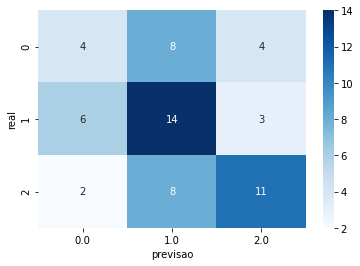

In [1180]:
cf_matrix=pd.crosstab(df_pred['result_test'], df_pred['result'], rownames=['real'], colnames=['previsao'])

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

## 3.0 Export Model Pickle

In [99]:
with open('knn_world_cup_model', 'wb') as f:
    pickle.dump(clf_MO, f)

In [100]:
with open('knn_world_cup_model', 'rb') as f:
    model_load = pickle.load(f)

In [101]:
model_load

MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=31), n_jobs=-1)